In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

Parameters and boundary conditions

In [ ]:
# todo: partial pressure + henry's law constant --> calculate c0
c0 = 1          # bulk concentration [mol/m^3], placeholder value
L = 100e-6      # diffusion layer length [m]
j = 5 * 1e-3 * 1e4      # electrode current density (default 5 mA/cm^2) [A/m^2]
D = 2e-9        # diffusion constant of CO2 [m^2/s]
F = 96485.33212 # Faraday constant [C/mol]
Npts = 100      # number of points on axis
d = 2           # dimension of the solution array, 2*number of species

## Boundary conditions
bc0_Neu = j/(2*D*F)  # let flux depend on current density
bc0_Dir = 0     # concentration zero for immediate reaction
bcL_Dir = c0    # bulk concentration at the end of the diffusion layer

Solving the differential equations

In [ ]:
def odes(x, y):
  """ 
  Define the right-hand side of a system of n first-order ODE's. 
  Arguments: 
    x: coordinate axis (mesh) with shape (m,)
    y: function values along the axis for each component of y. Shape (n,m)
  Returns:
    dydx: array with shape (n,m) containing the derivative for each component 
    of y at each x-position
  """ 
  dydx = np.zeros(y.shape)
  dydx[0,:] = y[1] # y0' = y1
  dydx[1,:] = 0    # y1' = 0
  return dydx 

def bcs(y0, yL):
  """
  Define the residuals of the boundary conditions -- the solver tries to make
  these zero. For n first-order ODE's there should be n boundary conditions.
  Arguments:
    y0: function value at x=0, shape (n,)
    yL: function value at x=L, shape (n,)
  Returns:
    residual: array with residuals to be minimized, shape (n,). The order of 
    these does not really matter. Each element is a function of y0 and yL. 
    For example, if the value of the third element (index 2) of y should be A 
    at x=0, the residual is y0[2] - A.
  """
  residual = np.zeros(y0.shape)
  residual[0] = yL[0] - bcL_Dir # residual for the BC for y0
  # residual[1] = y0[1] - bc0_Neu # residual for the BC for y1
  residual[1] = y0[0] - bc0_Dir # residual for the BC for y1
  return residual

x = np.linspace(0, L, Npts)

y_guess = np.zeros((d, Npts))
y_guess[0,:] = c0
y_guess[1,:] = c0/L

odesol = solve_bvp(odes, bcs, x, y_guess, verbose = 2)
xsol = odesol.x
y0sol = odesol.y[0,:]
y1sol = odesol.y[1,:]

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.23e-14       1.11e-16          100             0       
Solved in 1 iterations, number of nodes 100. 
Maximum relative residual: 1.23e-14 
Maximum boundary residual: 1.11e-16


Plotting the results

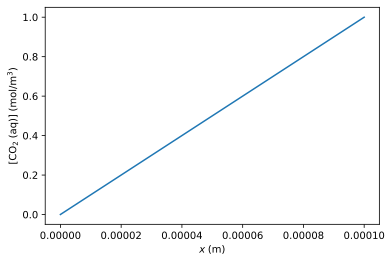

In [ ]:
plt.plot(xsol, y0sol)
plt.xlabel(r'$x \; \mathrm{(m)}$')
plt.ylabel(r'$\mathrm{[CO_2 \; (aq)]} \; \mathrm{(mol/m^3)}$')
plt.show()